# Streaming TimeSeries prediction using SPSS Flow deployed in WML

**(C) 2021 IBM - Philippe Gregoire - Ecosystem Advocacy Group Europe - Partners Technical Enablement**

## Prerequisites:
* A SPSS Flow with a Streaming Time Series node must be deployed to Watson Machine Learning
* An input file in CSV format with columns matching the deployed WML SPSS model must be present in Cloud Object Storage

## Operations
* We first load the CSV file from COS into a pandas DataFrame, `df_data`
* That dataframe is converted to an array of rows, each row itself being an array or individual values.
* We initialize the WML client with the WML credentials where that model is deployed.
* The array of timeseries values is fed into a WML prediction call
* The predictions are returned in JSON-formatted text
* We convert the text to JSON (Python dictionary) and then back to a Results DataFrame
* The predictions DataFrame is then stored in a new file in COS

## Notes
* Here we assume that the input CSV file has been created in COS from its DB2 data source tables, using a Data refinery flow that has joined the two
* We could also connect directly to the DB2 tables and build the dataframe from there rather than going through COS

### First step: Insert project token
From the vertical ellipsis button at the top right, select `Insert project token` 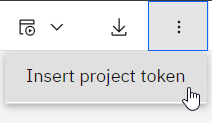

==> This creates a new code cell as the first cell in the notebook, scroll up from here and execute it

In [ ]:
# test if we have a project context now
try:
    print(f"Project name: {project.get_name()}")
except:
    print("No project context, please insert project token and Run resulting cell")

### Upload the Deployment Space APIKey `json` file
* obtain an API Key from https://cloud.ibm.com/iam/apikeys
* Open the Add data panel from the menu at the top right 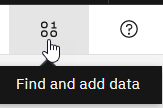
* Upload the `AccountAPIKey.json` file to the Data files

In [ ]:
# Load the APIKey
import json
try:
    apikey=json.load(project.get_file('AccountAPIKey.json'))
    print(f"Loaded API Key {apikey['name']}")
except:
    print(f"API Key not loaded, 'AccountAPIKey.json' file is not a data asset, please add it")

> **NOTE**: You will have to insert your spaceID down below
It can be foundin the deployment space Manage tab, under Space GUID

In [ ]:
# Setup some constants
# Name of the timestamp field/column
key_ts='DATE_'
# Number of Markets
MarketMax=85
# Name of WML model
TSModelName='Online_Market_Predict'
#
location='us-south'
# SpaceID from the space's properties
spaceID='d58d26ff-40c6-4e51-961b-71dabff4ab06'

## Load the data to score from file into a dataframe 

In [ ]:
# Read the input Time Series file
import pandas as pd
df_ts = pd.read_csv(project.get_file('broadband.csv'))
df_ts.describe()

In [ ]:
# Adjust types, so that we can sort on timestamp
df_ts[key_ts]=pd.to_datetime(df_ts[key_ts])
# show some statistics
df_ts.dtypes.to_frame().transpose().append(df_ts.describe())

In [ ]:
# plot Market_1 to market_5 after setting index to the DATE_ column
df_ts.set_index(key_ts)[['Market_{}'.format(x+1) for x in range(0,MarketMax)]].plot(figsize=(20,15));

In [ ]:
# Locate the WML model
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "apikey": apikey['apikey'],
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}
wmlClient = APIClient(wml_credentials)
wmlClient.set.default_space(spaceID)

In [ ]:
wmlClient.deployments.get_details()['resources']

In [ ]:
# Find our model deployment
res=wmlClient.deployments.get_details()['resources']
depls=[x['entity'] for x in res if x['entity']['name']==TSModelName]
if len(depls)>0:
    depl=depls[0]
    print(f"Got deployment for model {TSModelName}")
else:
    print(f"Deployment with name {TSModelName} not found. Existing deployments: {','.join([x['entity']['name'] for x in res])}")

In [ ]:
# Get the model details
model=wmlClient.repository.get_model_details(depl['asset']['id'])

In [ ]:
# Create a data frame structure that matches the model's 'input_data_schema'
input_columns=[x['name'] for x in model['entity']['schemas']['input'][0]['fields']]
df_ts=df_ts[input_columns]

In [ ]:
# Extract input table as array of values suitable for WML invocation input
values_ts=[[str(e) for e in r] for r in df_ts.itertuples(index=False,name=None)]
print("predicting with {} lines as input".format(len(values_ts)))
payload_predict = {"input_data":[{"fields": input_columns, "values": values_ts}]}

In [ ]:
# Score using the WML API
deplId=depl['status']['online_url']['url'].split('/')[-2]
predictions = wmlClient.deployments.score(deplId, payload_predict)

In [ ]:
# Convert response back to dataframe
dfPredict=pd.DataFrame.from_records(predictions['predictions'][0]['values'],columns=predictions['predictions'][0]['fields'])
# Convert TS column
dfPredict[key_ts]=pd.to_datetime(dfPredict[key_ts],format="%Y-%m-%d %H:%M %p %Z")
dfPredict

In [ ]:
# Plot
dfPredict.set_index(key_ts).plot(figsize=(20,15));

In [ ]:
# plot each market
marketNum=4
for marketNum in range(1,6):
    marketCols=[key_ts]
    [marketCols.append(x) for x in dfPredict.columns if x.endswith('Market_{}'.format(marketNum)) and x.find("Residual")==-1]
    dfPredict[marketCols].set_index(key_ts).plot(figsize=(20,3));
    dfPredict[[key_ts,'$TSResidual-Market_{}'.format(marketNum)]].set_index(key_ts).plot(figsize=(20,1));